In [6]:
from scipy.ndimage import uniform_filter, binary_dilation
from skimage import measure
import numpy as np
import blimpy as bl
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/home/cgchoza/galaxies/complete_cadences_catalog.csv')
df['.h5 path'] = df['.h5 path'].str.replace('0000.h5', '0002.h5', regex=False)
df = df.drop_duplicates(subset='.h5 path', keep='first').reset_index(drop=True)
df = df[~df['.h5 path'].str.contains('spliced')].reset_index(drop=True)
df = df.drop(index = 17546)
small_df = df.sample(n=100, random_state=42).reset_index(drop=True)

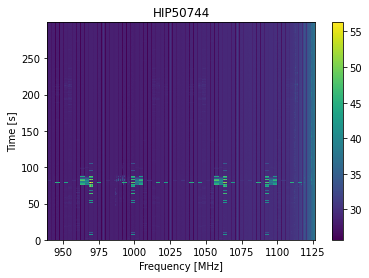

In [8]:
fb = bl.Waterfall(df['.h5 path'].iloc[-1], load_data=True)
fb.plot_waterfall()
# Load and process
data = fb.data.squeeze()
data = 10 * np.log10(data) # used for visualization

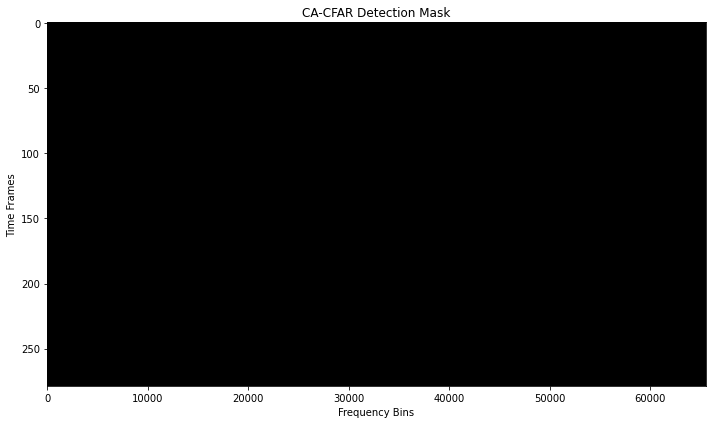

In [10]:
from scipy.ndimage import uniform_filter, binary_dilation
from skimage import measure

# CFAR parameters
guard = (7, 7)
train = (15, 15)
scale = 3.0

def ca_cfar_2d(img, guard, train, scale):
    kernel = (2 * train[0] + 2 * guard[0] + 1, 2 * train[1] + 2 * guard[1] + 1)
    gsize = (2 * guard[0] + 1, 2 * guard[1] + 1)

    # Total training + guard filter
    total_avg = uniform_filter(img, size=kernel)
    guard_avg = uniform_filter(img, size=gsize)

    n_total = np.prod(kernel)
    n_guard = np.prod(gsize)

    noise_est = (total_avg * n_total - guard_avg * n_guard) / (n_total - n_guard)
    threshold = noise_est * scale
    mask = img > threshold
    return mask

# Apply CFAR
cfar_mask = ca_cfar_2d(data, guard, train, scale)

# Clean-up: dilation + remove horizontal streaks
cfar_mask = binary_dilation(cfar_mask, structure=np.ones((3, 3)))

# Remove horizontal lines
labels = measure.label(cfar_mask)
props = measure.regionprops(labels)

for prop in props:
    minr, minc, maxr, maxc = prop.bbox
    h, w = maxr - minr, maxc - minc
    if h < w:  # horizontal
        cfar_mask[labels == prop.label] = 0



# Only plot the cleaned CA-CFAR detection mask
plt.figure(figsize=(10, 6))
plt.imshow(cfar_mask, aspect='auto', cmap='gray')
plt.title("CA-CFAR Detection Mask")
plt.xlabel("Frequency Bins")
plt.ylabel("Time Frames")
plt.tight_layout()
plt.show()
